# testing waveform retreival that is event-based from the NEIC

## WORKFLOW
need to get waveforms either from NEIC (faster) or IRIS (about 1+min latency... varies) with instrument responses, preferably already selected by timing around P-arrival and location
1. identify available stations and criteria (distance, networks, etc). This may be doable through [get_stations](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html#obspy.clients.fdsn.client.Client.get_stations) **Done**. 
    1. this currently also gets the response info.  If usable, then NEIC may be preferred for waveforms
1. use Taup to get event-times **Done**
    1. works and seems pretty darn fast (thankfully!)
1. create station-specific list based on event-times **Done**
1. pull data and response
    1. IRIS allows for response
    1. if NEIC, need to add response from other source  **Done (merging response info too easy)**
1. add event time with data **Done**


In [13]:
# from running code
"""
program to get event-based waveform data around theoretical P-arrival time
from the NEIC server, and including instrument response removal from IRIS
to the traces, the following informaiton is added:
     stats.phasePtime  (using IASP91)
     stats.coordinates ({'latitude': slat, 'longitude': slon})
     stats.distance    (in meters around great circle)
Stations currently default to the GSN network
 Andrew Newman  Fri Jul 23 18:56:10 UTC 2021
"""

from obspy import UTCDateTime
from obspy.core.stream import Stream
from compress_pickle import dump,load  # reading/writing compressed pickles
from rtergpy.waveforms import get_respinv, get_neicwaves,etime2name
import os
import shutil
import pandas as pd

### params
### need to determine best method for program arch.  May best be done as all function calls
# event
eloc = [13.80,120.50,104]
etime= UTCDateTime(2021,7,23,20,49,00)   # recent M7 in eastern Indonesia

ecount=1  # stepped count checking for prior events on that date  //TODO will be added later
#runiter=1  # stepped count of event iteration       //TODO will determined later
class iterate:
    count = 0
    def str(self):
       return str(iterate.count).zfill(2)
    def step(self):
       iterate.count += 1

runiter = iterate() 
# runiter.count gives current count
# runiter.str() gives as a 2digit string leading zero
# runiter.step() increases iteration by 1

eventname=etime2name(etime,ecount)

## general
network = "CU,GT,IC,II,IU" # GSN network
rads=[25,80]
chan="BHZ"
prePtime=60
postPtime=300

edirbase="/Users/anewman/Documents/Projects/rterg/processing/Examples/events"
edir=os.path.join(edirbase,str(etime.year),eventname) # event directory
edirit=os.path.join(edir,runiter.str())  # iteration

# get original running directory
owd = os.getcwd()  
if os.path.exists(edirit):
     try:
          bakdir=edirit+".bak"
          shutil.move(edirit,bakdir)
     except:
          print("ERROR:  coudn't move directory to ",bakdir)

try:
     os.makedirs(edirit)
     try:
          os.chdir(edirit)
          print("New working directory: ", edirit)
     except:
          print("ERROR:  Couldn't get to directory: ", edirit)
except:
     print("Error:  Couldn't create directory: ", edirit)


# run
t1 = UTCDateTime() # time run

print("Checking for stations available within range from IRIS")
inventory = get_respinv(network,eloc,etime,rads,chan) # from fsdn
print("Pulling Waveforms from NEIC")
st = get_neicwaves(inventory, eloc, etime, prePtime, postPtime)  # stream


# waveform processing
st_raw=st.copy()  # create backup

# process data
st.detrend(type='demean')
st.taper(0.05)
st.remove_response()
st.filter("bandpass", freqmin=0.01, freqmax=2)

now=UTCDateTime()
runtime=now-t1
print("\nRuntime: ",runtime, " sec.")


New working directory:  /Users/anewman/Documents/Projects/rterg/processing/Examples/events/2021/2021072301/00
Checking for stations available within range from IRIS
Pulling Waveforms from NEIC
added:  IC.BJT.00.BHZ
added:  IC.HIA.00.BHZ
added:  IC.LSA.00.BHZ
added:  IC.LSA.10.BHZ
added:  IC.MDJ.00.BHZ
added:  IC.MDJ.60.BHZ
added:  II.AAK.00.BHZ
added:  II.AAK.10.BHZ
added:  II.ABPO.00.BHZ
added:  II.ABPO.10.BHZ
added:  II.ARTI.00.BHZ
added:  II.BORK.10.BHZ
added:  II.COCO.00.BHZ
added:  II.COCO.10.BHZ
added:  II.DGAR.00.BHZ
added:  II.DGAR.10.BHZ
added:  II.ERM.00.BHZ
added:  II.ERM.10.BHZ
added:  II.KDAK.00.BHZ
added:  II.KDAK.10.BHZ
added:  II.KIV.00.BHZ
added:  II.KURK.00.BHZ
added:  II.KURK.10.BHZ
added:  II.KWJN.00.BHZ
added:  II.KWJN.10.BHZ
added:  II.LVZ.00.BHZ
added:  II.MSEY.00.BHZ
added:  II.MSEY.10.BHZ
added:  II.MSVF.00.BHZ
added:  II.MSVF.10.BHZ
- skip - : II.NIL.10.BHZ
added:  II.OBN.00.BHZ
added:  II.PALK.00.BHZ
added:  II.PALK.10.BHZ
added:  II.RAYN.00.BHZ
added:  II.RA

In [28]:
#dfline={"eventname":eventname,"etime":etime,"eloc":[eloc],"network":network,"chan":chan,"rads":rads,
#       "Pwin":[[prePtime,postPtime]],"modtime":now,"runtime":runtime,"inventory":[inventory]}
dfline={"eventname":eventname,"etime":etime,"eloc":[eloc],"network":network,"chan":chan,"rads":[rads],
       "Pwin":[[prePtime,postPtime]],"modtime":now,"runtime":runtime,"inventory":[inventory]}
df=pd.DataFrame(dfline, dtype=object)


In [2]:
from obspy.clients.fdsn import Client as fdsnClient
from obspy import UTCDateTime

### params
# event
eloc = [7.39,-82.5,33]
etime= UTCDateTime(2021,7,21,21,15,15)   # recent mid-6 in Panama
eloc = [13.80,120.50,104]
etime= UTCDateTime(2021,7,23,20,49,00)   # M7 in philip/indo.
## general
network = "CU,GT,IC,II,IU" # GSN network
rads=[25,80]
chan="BHZ"
prePtime=60
postPtime=300

def get_inventory(network,eloc,etime,rads,chan):
    from obspy.clients.fdsn import Client as fdsnClient
    from obspy import UTCDateTime
    fclient = fdsnClient()
    now=UTCDateTime()

    elat,elon,edep = eloc
    minrad,maxrad = rads 
    
    inventory = fclient.get_stations(network = network, 
            latitude = elat, longitude = elon, 
            minradius = minrad, maxradius = maxrad, 
            starttime=etime-86400, endtime=etime,
            channel=chan,
            #location="00",
            matchtimeseries=True,
            #filename="test.txt", format="text",  # cannot be used with response
            #filename="test.xml", format="xml",
            level="response"
            )
    return inventory  # this is an Obspy type
    
inventory = get_inventory(network,eloc,etime,rads,chan)

# get individual streams and print location info
#for chan in inventory.get_contents().get("channels"):
#    print(chan, 
#          inventory.get_coordinates(chan), 
#          inventory.get_response(chan, now)
#         )
print(inventory);
#print(inventory[0][0]);  # first station of the first network



Inventory created at 2021-07-28T14:03:18.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2021-07-22...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (3):
			IC, II, IU
		Stations (56):
			IC.BJT (Baijiatuan, Beijing, China)
			IC.HIA (Hailar, Neimenggu Autonomous Region, China)
			IC.LSA (Tibet, China)
			IC.MDJ (Mudanjiang, Heilongjiang Province, China)
			II.AAK (Ala Archa, Kyrgyzstan)
			II.ABPO (Ambohimpanompo, Madagascar)
			II.ARTI (Arti, Russia)
			II.BORK (Burabay, Kazakhstan)
			II.COCO (West Island, Cocos (Keeling) Islands)
			II.DGAR (Diego Garcia, Chagos Islands, Indian Ocean)
			II.ERM (Erimo, Hokkaido Island, Japan)
			II.KDAK (Kodiak Island, Alaska, USA)
			II.KIV (Kislovodsk, Russia)
			II.KURK (Kurchatov, Kazakhstan)
			II.KWJN (Gagan, Kwajalein Atoll, Marshall Islands)
			II.LVZ (Lovozero, Russia)
			II.MSEY (Mahe, Seychelles)
			II.MSVF (Monasavu, Fiji)
			II.NIL 

## get Ptimes for those channels and input into call to pull waveforms from NEIC

In [2]:
from obspy.taup import TauPyModel
from obspy.core.stream import Stream
model = TauPyModel(model="iasp91")
from obspy.geodetics.base import locations2degrees as l2d
from obspy.geodetics.base import degrees2kilometers as d2km

from obspy.clients.neic import Client as nClient
nclient=nClient()

def theorPtime(eloc,etime,sloc):
    elat,elon,edep=eloc
    slat,slon,sheight=sloc
    arrivals=model.get_travel_times_geo(
        source_depth_in_km=edep, source_latitude_in_deg=elat, source_longitude_in_deg=elon,
        receiver_latitude_in_deg=slat, receiver_longitude_in_deg=slon,
        phase_list="P")
    return etime + arrivals[0].time

def loc2km(eloc,sloc):
    elat,elon,edep=eloc
    slat,slon,sheight=sloc
    distdeg=d2km(l2d(elat,elon,slat,slon))
    return distdeg
    

st=Stream()
st.clear()  # clear just in case

# run on all channels in inventory
t1 = UTCDateTime()
for chan in inventory.get_contents().get("channels"):
    slat,slon,sz,sldep=inventory.get_coordinates(chan).values()
    sheight=sz-sldep
    sloc=slat,slon,sheight
    Ptime=theorPtime(eloc,etime,sloc)
    neti,stati,loci,chani=chan.split(".")
    stlocal=nclient.get_waveforms(neti,stati,loci,chani,Ptime-prePtime,Ptime+postPtime)
    if stlocal:
        # add station coordinates
        try:
            stlocal[0].stats.coordinates= {'latitude': slat, 'longitude': slon}
        except:
            print ("Channel ", chan, " did not add event locations")
        # add distance
        try:
            stlocal[0].stats.distance=loc2km(eloc,sloc)*1000;  # distance should be reported in meters!
        except:
            print ("Channel ", chan, " did not calc distance")
        # add theoretical P-time
        try:
            stlocal[0].stats.phasePtime=Ptime;  # UTC time of P-arrival
        except:
            print ("Channel ", chan, " Ptime not added")
        st+=stlocal
        print("added: ",chan)
    else:
        print("- skip - :", chan)
        
    #print(chan,Ptime)
    # lets get waveforms here as a looped request.
print("\nRuntime: ", UTCDateTime()-t1, " sec.")
stback=st.copy()  # create backup


added:  IC.BJT.00.BHZ
added:  IC.HIA.00.BHZ
added:  IC.LSA.00.BHZ
added:  IC.LSA.10.BHZ
added:  IC.MDJ.00.BHZ
added:  IC.MDJ.60.BHZ
added:  II.AAK.00.BHZ
added:  II.AAK.10.BHZ
added:  II.ABPO.00.BHZ
added:  II.ABPO.10.BHZ
added:  II.ARTI.00.BHZ
added:  II.BORK.10.BHZ
added:  II.COCO.00.BHZ
added:  II.COCO.10.BHZ
added:  II.DGAR.00.BHZ
added:  II.DGAR.10.BHZ
added:  II.ERM.00.BHZ
added:  II.ERM.10.BHZ
added:  II.KDAK.00.BHZ
added:  II.KDAK.10.BHZ
added:  II.KIV.00.BHZ
added:  II.KURK.00.BHZ
added:  II.KURK.10.BHZ
added:  II.KWJN.00.BHZ
added:  II.KWJN.10.BHZ
added:  II.LVZ.00.BHZ
added:  II.MSEY.00.BHZ
added:  II.MSEY.10.BHZ
added:  II.MSVF.00.BHZ
added:  II.MSVF.10.BHZ
- skip - : II.NIL.10.BHZ
added:  II.OBN.00.BHZ
added:  II.PALK.00.BHZ
added:  II.PALK.10.BHZ
added:  II.RAYN.00.BHZ
added:  II.RAYN.10.BHZ
- skip - : II.SIMI.00.BHZ
added:  II.TAU.00.BHZ
added:  II.TAU.10.BHZ
added:  II.TLY.00.BHZ
added:  II.UOSS.00.BHZ
added:  II.UOSS.10.BHZ
added:  II.WRAB.00.BHZ
added:  II.WRAB.10.BHZ

In [3]:
st=stback.copy();  # for rerunning below on existing data
print(len(st))

92


In [11]:
import pandas as pd

dfline={'eloc': [eloc],'inventory': [inventory]}
df=pd.DataFrame(dfline, dtype=object)


In [12]:
df


,eloc,inventory
0,"[13.8, 120.5, 104]","(((Channel 'BHZ', Location '00' \n\tTime range..."


In [ ]:
class eventparams:
     def __init__(self):
          self.eventname=eventname
          self.etime=etime
          self.eloc=eloc
          self.network=network
          self.rads=rads
          self.chan=chan
          self.Pwin=[prePtime,postPtime]
          self.edirit=edirit
          self.now=now
          self.runtime=runtime
          self.inventory=inventory



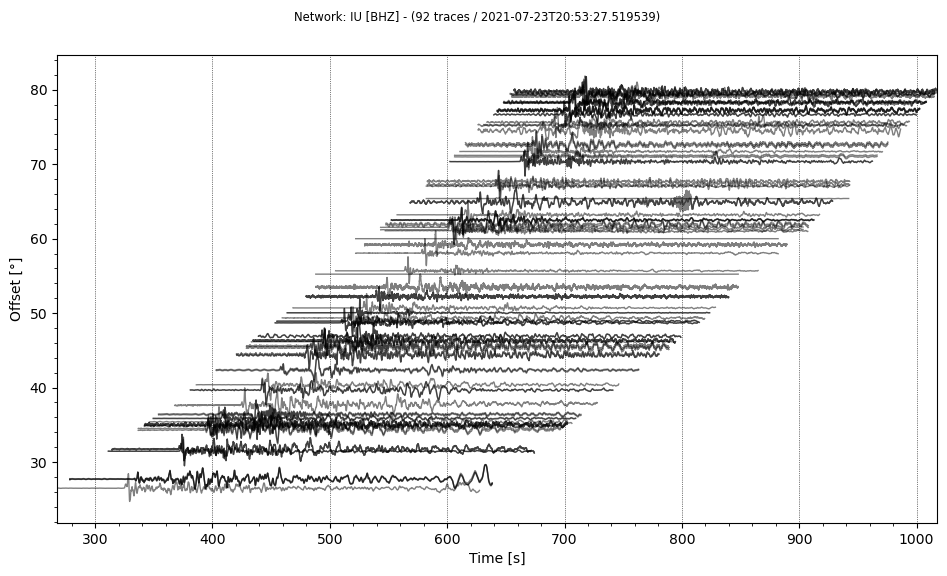

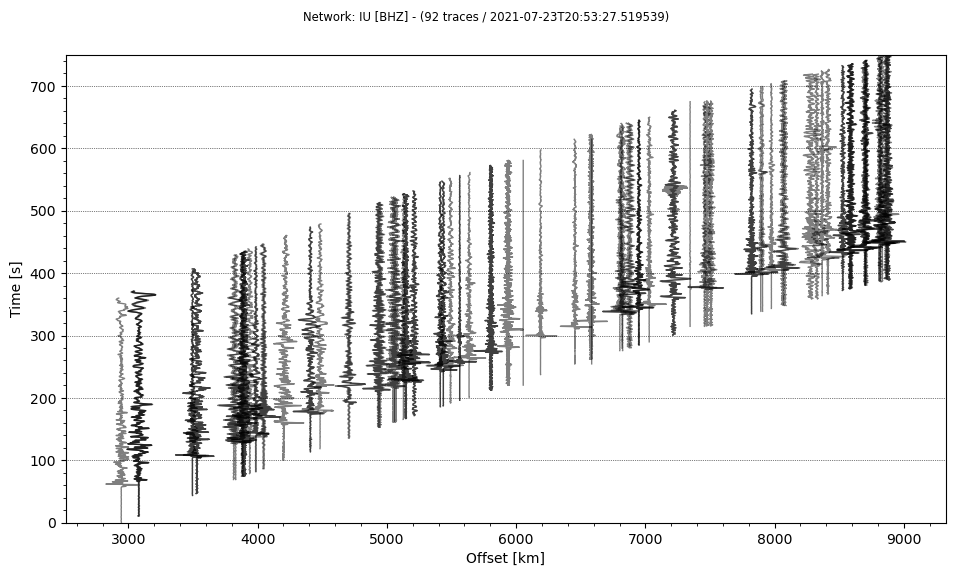

In [3]:
# plotting everything (info here : https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.plot.html#obspy.core.stream.Stream.plot)
# tricky to get everything needed in there (needs both station coordinates included in traces and local reporting of event location)
# added reference relative to EQ origin and horizontal plotting.
st.plot(type='section', scale=5, dist_degree=True, ev_coord=[eloc[0],eloc[1]], orientation='horizontal', reftime=etime);

# simpler.  Still requires distance attribute in meters
st.plot(type='section', scale=3);

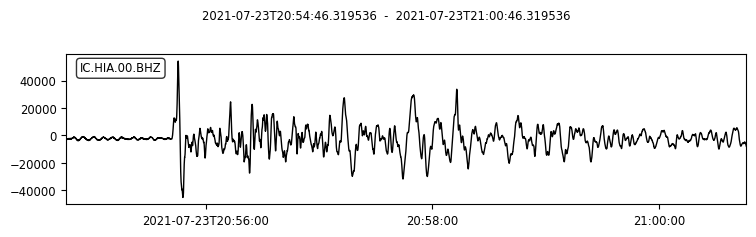

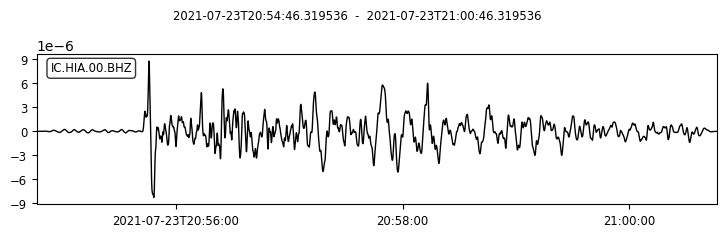

In [5]:
st=stback.copy();  # start fresh
st.attach_response(inventory) # include response information
st[1].plot();  
st.detrend(type='demean')
st.taper(0.05)
st.remove_response()
st.filter("bandpass", freqmin=0.01, freqmax=2)
st[1].plot();

82 Trace(s) in Stream:

II.AAK.00.BHZ | 2021-07-23T20:56:34.919538Z - 2021-07-23T21:02:34.919538Z | 20.0 Hz, 7201 samples
...
(80 other traces)
...
IU.YSS.00.BHZ | 2021-07-23T20:55:07.900000Z - 2021-07-23T21:01:07.900000Z | 20.0 Hz, 7201 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


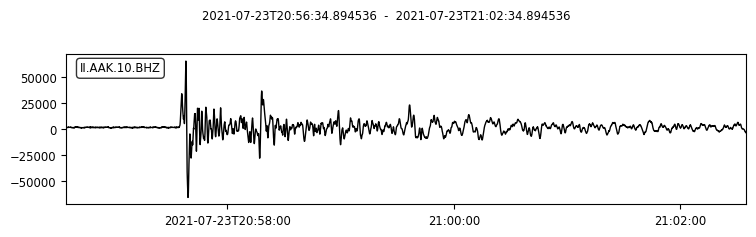

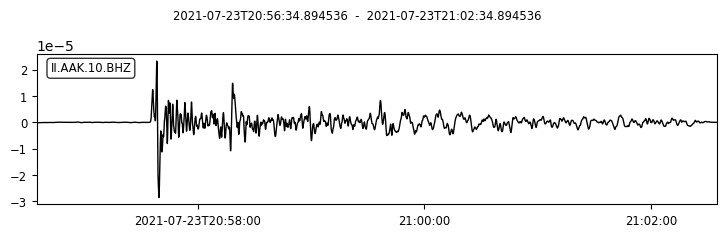

In [7]:
st=stback.copy();
print(st);
#st.plot(type="relative",equal_scale=False);
st.attach_response(inventory)

st[1].plot();
#st[1].spectrogram();
st[1].detrend(type='demean');
st[1].taper(.05);
st[1].remove_response()
st[1].filter("bandpass", freqmin=.01, freqmax=2 )
st[1].plot();
#st[1].spectrogram();


# TESTING

## phase picking

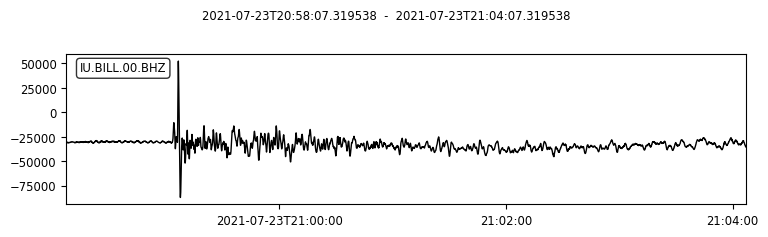

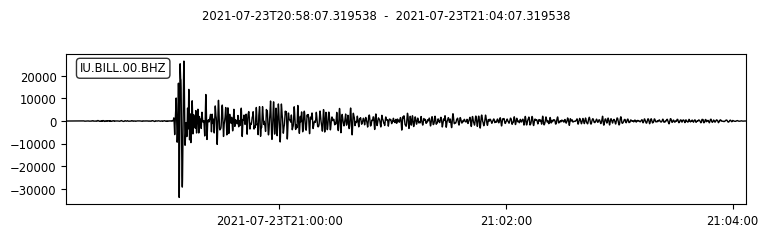

df =  20.0
First Trigger =  57.25


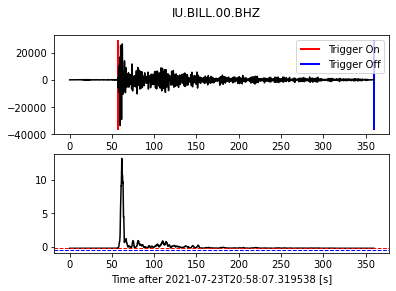

In [8]:

tr = st[39].copy()
tr.plot();
tr.detrend(type='demean');
tr.taper(.05);
tr.filter("bandpass", freqmin=.5, freqmax=2 )
df = tr.stats.sampling_rate
tr.plot();


## Baer Picker
#from obspy.signal.trigger import pk_baer
#Ppick,phase_info = pk_baer(tr.data, df, 20, 30, 15., 20., 10, 10)
#print(Ppick, Ppick/df)

## Z-detect
from obspy.signal.trigger import z_detect
from obspy.signal.trigger import plot_trigger
from numpy import where

print("df = ", df)
cft = z_detect(tr.data, int(2*df) )

on=-0.2 ; off = on-0.2

idx=where(cft > on)
print("First Trigger = ", idx[0][0]/df)  # first value

plot_trigger(tr,cft, on, off)
#print(cft);

#from matplotlib import pyplot as plt
#fig = plt.plot(cft)




## last 30 s from all IU BHZ stations 

In [52]:
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader

In [58]:
ot=UTCDateTime()-3600
domain=CircularDomain(latitude=35, longitude=-84, minradius=15, maxradius=80)
restrictions=Restrictions(starttime=ot -10,
                         endtime=ot+60,
                         reject_channels_with_gaps=True,
                         minimum_length=0.75,
                         minimum_interstation_distance_in_m=10e3,
                         channel="BHZ",
                         network=["IU", "TA"],
                         location_priorities=["","00","10"])
mdl = MassDownloader(providers=["IRIS"])
mdl.download(domain, restrictions, mseed_storage="data",stationxml_storage="stations")

[2021-07-22 12:08:14,718] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2021-07-22 12:08:14,723] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2021-07-22 12:08:14,724] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2021-07-22 12:08:14,725] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2021-07-22 12:08:15,073] - obspy.clients.fdsn.mass_downloader - ERROR: Client 'IRIS' - Failed getting availability: Bad request. If you think your request was valid please contact the developers.
Detailed response of server:

Error 400 BAD_REQUEST: Invalid input parameter: net|network=['IU'
Request:
http://service.iris.edu/fdsnws/station/1/query?starttime=2021-07-22T15%3A08%3A04.718183&endtime=2021-07-22T15%3A09%3A14.718183&network=%5B%27IU%27%2C+%27TA%27%5D&channel=BHZ&level=channel&latitude=35.0&longitude=-84.0&minradius=15.0&maxradi

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7ff0416528e0>}